# OG/No OG Simulation Pairs

In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as const
import rebound as reb
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

import celmech
from celmech import Poincare, PoincareHamiltonian
from celmech.secular import LaplaceLagrangeSystem
from celmech.nbody_simulation_utilities import align_simulation

import gap_complexity_utils as gaps
from gap_complexity_utils import SimulationPair, EnsemblePair

In [2]:
simpair = SimulationPair(5, rng_seed=420)
simpair.add(m=1.0e-3, a=5.0)

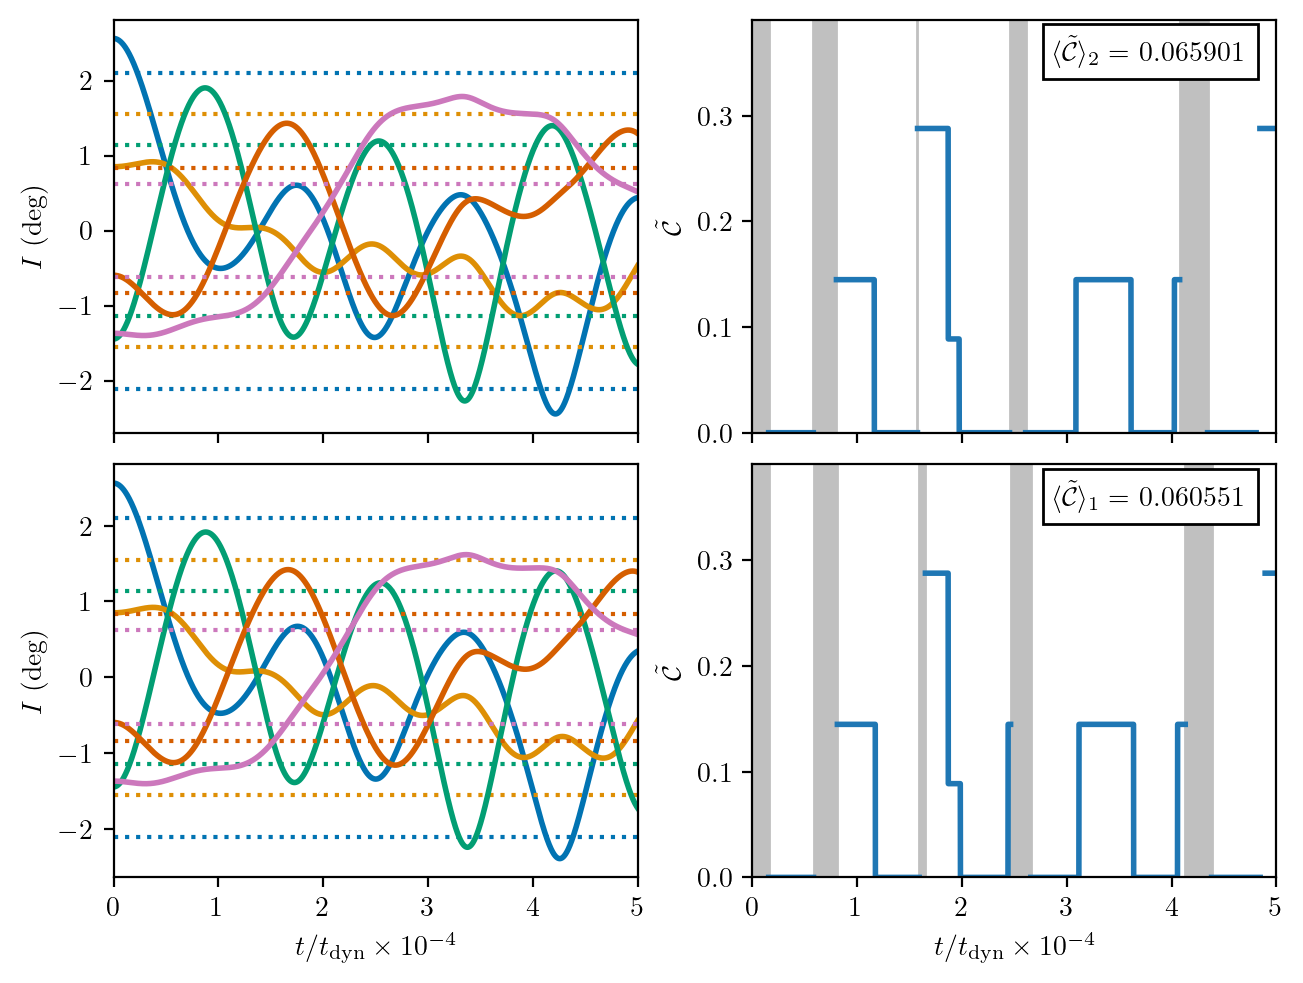

In [3]:
simpair.get_ll_systems()
simpair.get_ll_solutions()
simpair.get_gap_complexities()
simpair.plot('inc', save=True)

# Ensembles of OG/No OG Pairs

In [4]:
my_ensemble = EnsemblePair(1_000, 4)
my_ensemble.set_og_mass_dist(np.random.uniform, 1.0e-3, 0.05)
my_ensemble.set_og_sma_dist(np.random.uniform, 5.0, 20.0)
my_ensemble.sample()

In [3]:
my_ensemble.run()

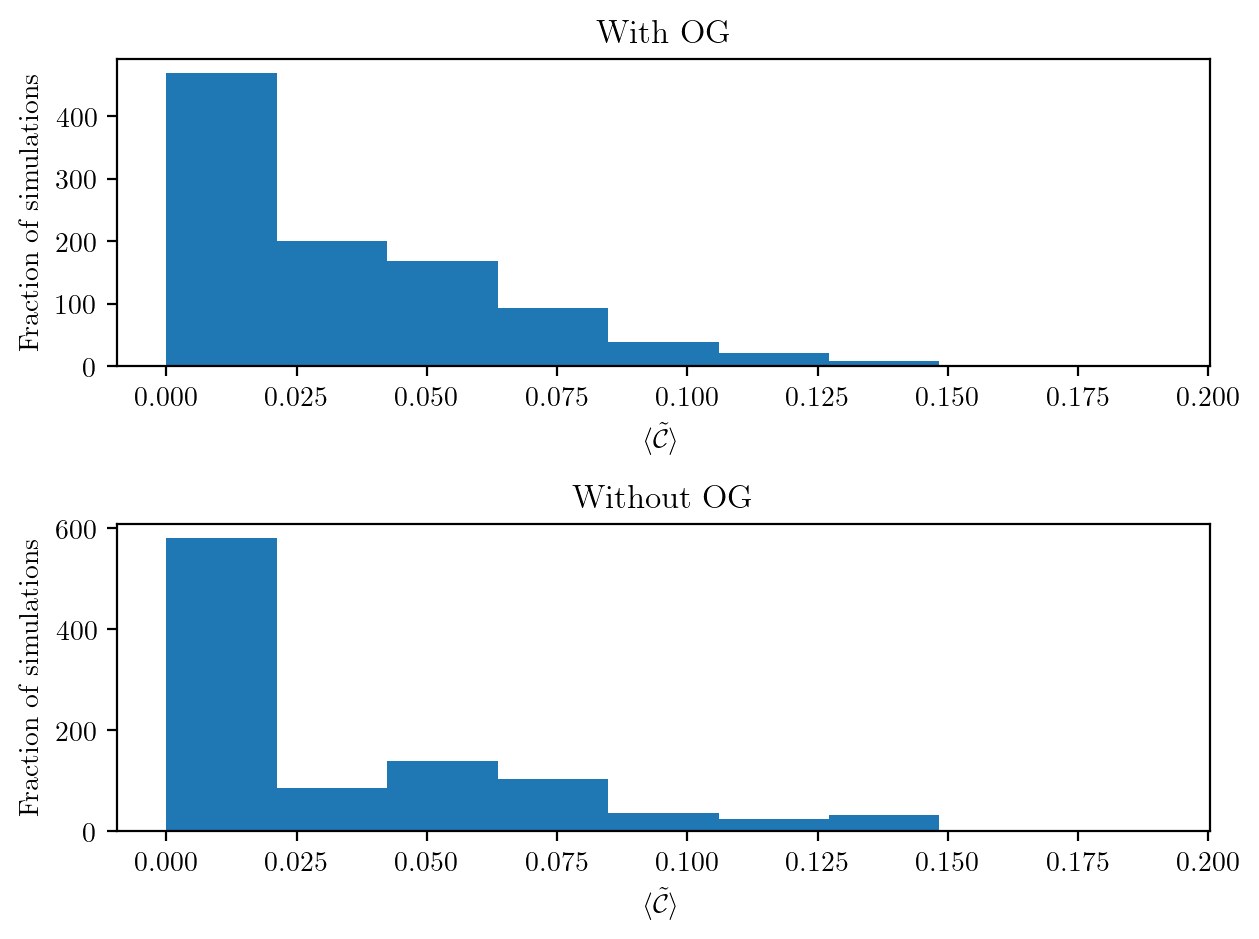

In [4]:
my_ensemble.histogram()

# The theory part

Why might the gap complexity respond to the presence of OGs more than to SCs? SCs are both more massive and more distant than OGs, in general. Switching from one to the other, the change enters the calculation through the secular matrix ($\bf{B}$). Holding the properties of some STIP planet constant, the corresponding elements of the secular matrix are all
$$
B_{jj} \propto B_{jk} \propto m_k \alpha_{jk} \bar{\alpha}_{jk} b^{(1)}_{3/2}(\alpha_{jk}),
$$
where $m_k$ is the outer companion mass and each of $\alpha_{jk}$,
$$
\bar{\alpha}_{jk} = \begin{cases} \alpha_{jk}, & \alpha_{jk} < 1 \\ 1, & \alpha_{jk} \geq 1 \end{cases},
$$
and the Laplace coefficient $b^{(1)}_{3/2}(\alpha_{jk})$ are pure functions of the semi-major axis.

In [2]:
from pylaplace import LaplaceCoefficient
coeff = LaplaceCoefficient()
def laplace_coefficient(ratio):
    return coeff(ratio, 1.5, 1., 1., 1.)

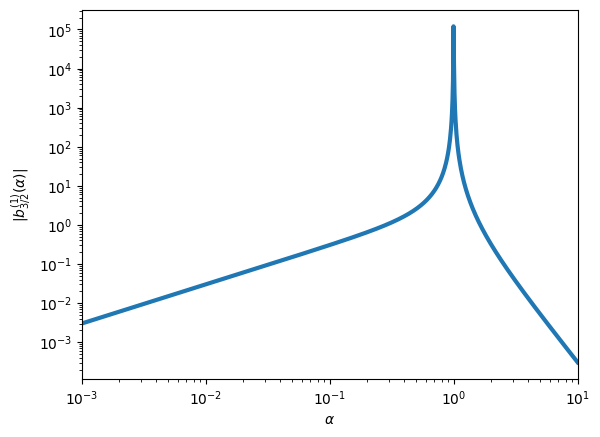

In [3]:
ain = np.logspace(-3.0, 1.0, 1000)
bb = np.array([laplace_coefficient(a) for a in ain])

plt.loglog(ain, np.abs(bb), lw=3)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$|b^{(1)}_{3/2}(\alpha)|$')
plt.xlim(ain.min(), ain.max());

In [4]:
def the_function(mass, alpha):
    alpha_bar = 0.0; b = 0.0
    if type(alpha) == np.ndarray:
        if alpha.any() > 1.0:
            alpha_bar = np.ones_like(alpha)
        else:
            alpha_bar = alpha
        b = np.empty(alpha.shape)
        for i in range(len(alpha[0])):
            for j in range(len(alpha[1])):
                b[i, j] = laplace_coefficient(alpha[i, j])
    else:
        if alpha > 1.0:
            alpha_bar = 1.0
        else:
            alpha_bar = alpha
        b = laplace_coefficient(alpha)
    return np.abs(mass * alpha * alpha_bar * b)

In [5]:
## Data for KGPS systems with 3+ STIP planets from Weiss+ 2023
## m_star in solar masses, m_og in Earth masses, distances in au

system_list = [
    # KOI-85 -- 3 TIP, 1 OG
    {'name': 'Kepler-65', 'm_star': 1.24, 'm_og': 217.0, 'alpha': 0.85 / 0.085},

    # KOI-316 -- 3 TIP, 1 OG
    {'name': 'Kepler-139', 'm_star': 1.08, 'm_og': 430.0, 'alpha': 3.2 / 0.58},

    # KOI-148 -- 3 TIP, 2 OG
    {'name': 'Kepler-48', 'm_star': 0.91, 'm_og': 687.0, 'alpha': 1.9 / 0.23},

    # KOI-351 -- 7 TIP, 1 OG
    {'name': 'Kepler-90', 'm_star': 1.11, 'm_og': 236.0, 'alpha': 0.97 / 0.72},

    # KOI-2169 -- 4 TIP, SC
    {'name': 'Kepler-1130', 'm_star': 0.94, 'm_og': 7.047e+4, 'alpha': 12.0 / 0.06},

    # KOI-3158 -- 5 TIP, SC
    {'name': 'Kepler-444', 'm_star': 0.73, 'm_og': 2.0e+5, 'alpha': 52.2 / 0.078},
]

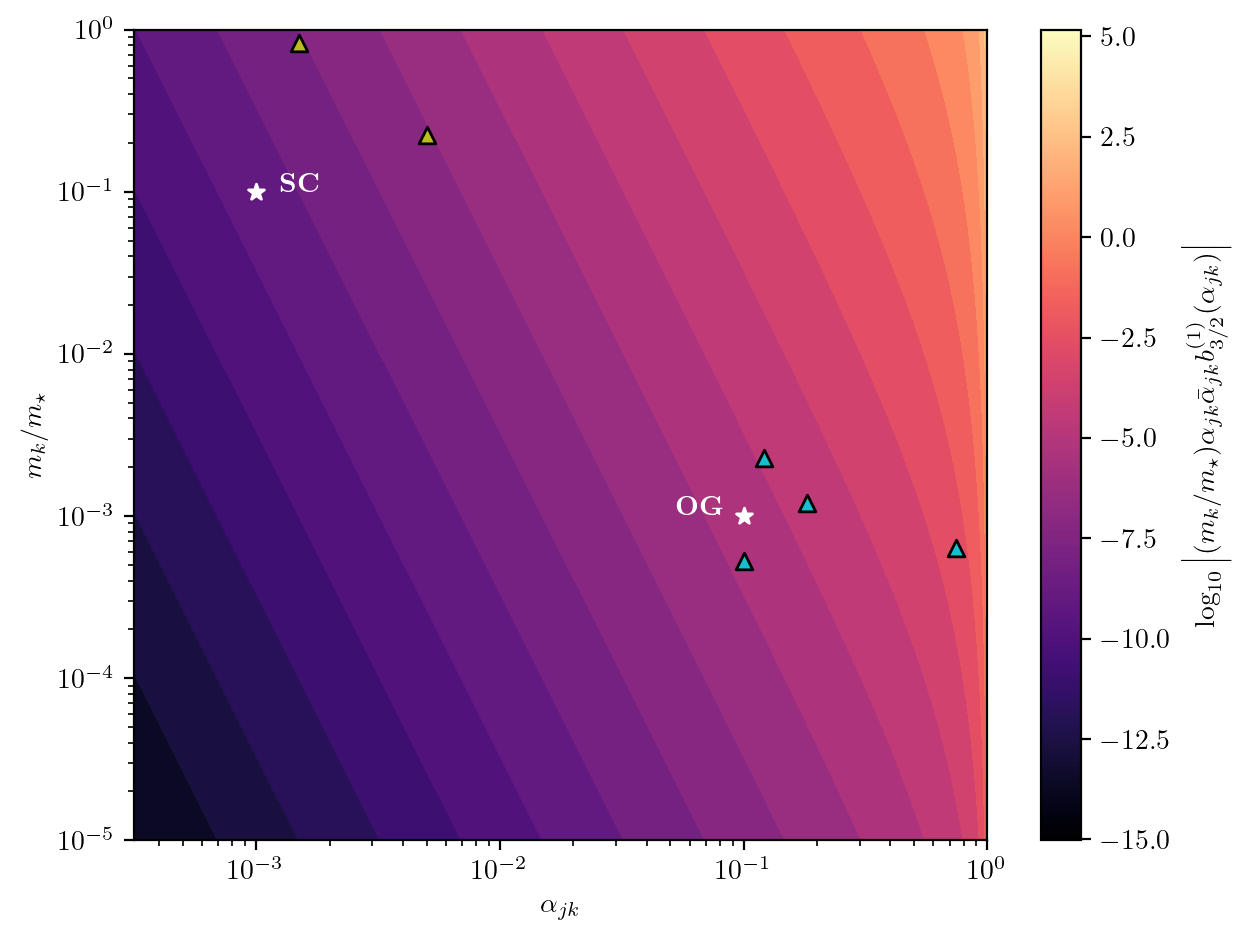

In [22]:
from matplotlib import cm, colors, ticker
cmap = cm.magma
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'cmu-serif'

mm = np.logspace(-5.0, 0.0, 1000)
aa = np.logspace(-3.5, 0.1, 1000)

_a, _m = np.meshgrid(aa, mm)
prod = the_function(_m, _a)

fig, ax = plt.subplots(1, 1, dpi=200)
ax.contourf(_a, _m, prod, locator=ticker.LogLocator(numticks=100), cmap=cmap)
cb = plt.colorbar(cm.ScalarMappable(
        norm=colors.Normalize(
            vmin=np.log10(np.nanmin(prod)),
            vmax=np.log10(np.nanmax(prod[prod != np.inf])),
        ),
        cmap=cmap,
    ),
    ax=ax,
)
ax.set_xlim(right=1.0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha_{jk}$')
ax.set_ylabel(r'$m_k / m_\star$')
cb.set_label(r'$\log_{10} \left | (m_k / m_\star) \alpha_{jk} \bar{\alpha}_{jk} b^{(1)}_{3/2}(\alpha_{jk}) \right |$')

ax.scatter(0.1, 0.001, c='w', marker='*')
ax.text(0.053, 0.001, r'\bf{OG}', c='w')

ax.scatter(0.001, 0.1, c='w', marker='*')
ax.text(0.00125, 0.1, r'\bf{SC}', c='w')

for system in system_list:
    rel_mass = system['m_og'] / system['m_star'] * const.M_earth / const.M_sun
    alpha = 1.0 / system['alpha']
    color = 'tab:cyan'
    if rel_mass > 1.0e-2:
        color = 'tab:olive'
    ax.scatter(alpha, rel_mass, c=color, marker='^', edgecolors='k')

fig.tight_layout()
# fig.savefig('secular-matrix-scaling.pdf');